# HW 1 part 2: **EDA**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re
from ydata_profiling import ProfileReport
import sklearn

# For displaying seaborn graphs in VSCode
%matplotlib widget

random.seed(42)
np.random.seed(42)

## 1. Data preprocessing

Code was copied from HW 1 part 1 ipynb

In [2]:
# Download raw data
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

In [3]:
# Fill in the blank values

###################
# mileage
###################

# Извлекаем суффиксы
df_train_mileage_suffix = df_train['mileage'].astype(str).str.replace(r"^[\d,\. ]+", '', regex=True)

# Заменяем none на 0
df_train_clean = df_train.copy()
df_test_clean = df_test.copy()
df_train_clean['mileage_kmpl'] = df_train_clean['mileage']
df_test_clean['mileage_kmpl'] = df_test_clean['mileage']

# Конвертируем в kmpl, убираем суффиксы
for df in [df_train_clean, df_test_clean]:
    mileage_suffix = df['mileage'].astype(str).str.replace(r"^[\d,\. ]+", '', regex=True)
    df.loc[mileage_suffix == 'kmpl', 'mileage_kmpl'] = df.loc[mileage_suffix == 'kmpl', 'mileage_kmpl'].astype(str).str.removesuffix(' kmpl').astype(float)
    df.loc[mileage_suffix == 'km/kg', 'mileage_kmpl'] = df.loc[mileage_suffix == 'km/kg', 'mileage_kmpl'].astype(str).str.removesuffix(' km/kg').astype(float) * 1.4

mileage_median = df_train_clean['mileage_kmpl'].dropna().median()

for df in [df_train_clean, df_test_clean]:
    df['mileage_kmpl'] = df['mileage_kmpl'].infer_objects(copy=False).fillna(mileage_median)

###################
# engine
###################

# Дальше мне стало лень переключаться на RU язык, поэтому комменты на EN

df_train_engine_suffix = df_train['engine'].astype(str).str.replace(r"^[\d,\. ]+", '', regex=True)

# Remove suffix, set nan to median
for df in [df_train_clean, df_test_clean]:
    df['engine_cc'] = df['engine'].astype(str).str.removesuffix(' CC')
    df['engine_cc'] = pd.to_numeric(df['engine_cc'], errors='coerce')

engine_median = df_train_clean['engine_cc'].median()

for df in [df_train_clean, df_test_clean]:
    df['engine_cc'] = df['engine_cc'].fillna(engine_median)

###################
# max_power
###################

# Remove suffix, set nan to median
for df in [df_train_clean, df_test_clean]:
    df['max_power_bhp'] = df['max_power'].astype(str).str.removesuffix(' bhp')
    df['max_power_bhp'] = pd.to_numeric(df['max_power_bhp'], errors='coerce')

max_power_median = df_train_clean['max_power_bhp'].median()

for df in [df_train_clean, df_test_clean]:
    df['max_power_bhp'] = df['max_power_bhp'].fillna(max_power_median)

###################
# torque
###################

# Below code is written by ChatGPT (this regexp is brutal, I'm too weak for this sorta thing):
###############################################################################################
pattern = re.compile(
    r"""
    ^\s*
    (?P<torque>\d+(?:\.\d+)?)                        # main torque number
    (?:\s*\(\s*(?P<torque_alt>\d+(?:\.\d+)?)\s*\))?  # optional (alt torque)
    \s*
    (?P<unit>nm|kgm)?                                # optional unit right after number
    \s*
    (?:                                              # optional RPM block
        (?:@|at|/)                                   # "@", "at" or "/"
        \s*
        (?P<rpm1>\d[\d,]*(?:\.\d+)?)                 # first rpm, allows "4,500"
        \s*
        (?:rpm)?                                     # optional "rpm"
        \s*
        (?:                                          # optional second rpm
            (?:[-~]|\+/-)                            # "-", "~" or "+/-"
            \s*
            (?P<rpm2>\d[\d,]*(?:\.\d+)?)             # second rpm, also with comma
            \s*
            (?:rpm)?                                 # optional "rpm"
        )?
    )?
    .*$
    """,
    re.IGNORECASE | re.VERBOSE
)

def parse_torque(df: pd.DataFrame) -> pd.DataFrame:
    # 1) Extract using the updated regex
    parsed = df['torque'].astype(str).str.extract(pattern)

    # 2) Clean commas in rpm strings BEFORE numeric conversion
    for col in ['rpm1', 'rpm2']:
        parsed[col] = parsed[col].str.replace(',', '', regex=False)

    # 3) Convert to numeric
    for col in ['torque', 'torque_alt', 'rpm1', 'rpm2']:
        parsed[col] = pd.to_numeric(parsed[col], errors='coerce')

    # 4) Detect unit from the full text, not just the regex group
    torque_text = df['torque'].astype(str).str.lower()
    is_kgm = torque_text.str.contains('kgm', na=False)
    is_nm  = torque_text.str.contains('nm', na=False)

    # prefer regex unit if present, otherwise infer
    unit = parsed['unit'].str.lower()
    unit = np.where(is_kgm, 'kgm',
        np.where(is_nm,  'nm', unit))

    # 5) Base torque value: main → alt
    base_torque = parsed['torque'].fillna(parsed['torque_alt'])

    # 6) Convert everything to Nm
    df['torque_nm'] = np.where(
        unit == 'kgm',
        base_torque * 9.80665,   # kgm -> Nm
        base_torque              # default: already Nm (or unknown)
    )

    # 7) RPM min/max
    rpm1 = parsed['rpm1']
    rpm2 = parsed['rpm2']

    rpm_min = rpm1.copy()
    rpm_max = rpm1.copy()

    has_rpm2 = rpm2.notna()
    rpm_min[has_rpm2] = np.minimum(rpm1[has_rpm2], rpm2[has_rpm2])
    rpm_max[has_rpm2] = np.maximum(rpm1[has_rpm2], rpm2[has_rpm2])

    df['torque_rpm_min'] = rpm_min
    df['torque_rpm_max'] = rpm_max
    return df

###############################################################################################

df_train_clean = parse_torque(df_train_clean)
df_test_clean = parse_torque(df_test_clean)

torque_nm_median = df_train_clean['torque_nm'].median()
torque_rpm_min_median = df_train_clean['torque_rpm_min'].median()
torque_rpm_max_median = df_train_clean['torque_rpm_max'].median()

for df in [df_train_clean, df_test_clean]:
    df['torque_nm'] = df['torque_nm'].fillna(torque_nm_median)
    df['torque_rpm_min'] = df['torque_rpm_min'].fillna(torque_rpm_min_median)
    df['torque_rpm_max'] = df['torque_rpm_max'].fillna(torque_rpm_max_median)

###################
# seats
###################

seats_median = df_train_clean['seats'].median()
df_train_clean['seats'] = df_train_clean['seats'].fillna(seats_median)
df_test_clean['seats'] = df_test_clean['seats'].fillna(seats_median)

# Remove columns with raw data that we already processed
for df in [df_train_clean, df_test_clean]:
    for fieldname in ['mileage', 'engine', 'max_power', 'torque']:
        del df[fieldname]

###################
# manufacturer
###################

car_manufacturers = [
 'Ambassador',
 'Ashok Leyland',
 'Audi',
 'BMW',
 'Chevrolet',
 'Daewoo',
 'Datsun',
 'Fiat',
 'Force Gurkha',
 'Force One',
 'Ford',
 'Honda',
 'Hyundai',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'Kia',
 'Land Rover',
 'Lexus',
 'MG Hector',
 'Mahindra',
 'Maruti',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Opel',
 'Peugeot',
 'Renault',
 'Skoda',
 'Tata',
 'Toyota',
 'Volkswagen',
 'Volvo'
]

def assign_class(x: str) -> str | None:
    for manufacturer in car_manufacturers:
        if x.startswith(manufacturer.strip()):
            return manufacturer

df_train_clean['manufacturer'] = df_train_clean['name'].apply(assign_class)
df_test_clean['manufacturer'] = df_test_clean['name'].apply(assign_class)

In [4]:
display(pd.concat([df_test_clean, df_train_clean]).isna().sum())

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
seats             0
mileage_kmpl      0
engine_cc         0
max_power_bhp     0
torque_nm         0
torque_rpm_min    0
torque_rpm_max    0
manufacturer      0
dtype: int64

In [5]:
display(df_train_clean.dtypes)

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
seats             float64
mileage_kmpl      float64
engine_cc         float64
max_power_bhp     float64
torque_nm         float64
torque_rpm_min    float64
torque_rpm_max    float64
manufacturer       object
dtype: object

In [6]:
# Remove duplicates
columns_wo_price = [col for col in df_train_clean.columns if col != 'selling_price']
df_train_clean = df_train_clean.drop_duplicates(columns_wo_price, keep='first')

# Reset index
df_train_clean = df_train_clean.reset_index(drop=True)
display(df_train_clean[-10:])
df_train_clean.shape

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_nm,torque_rpm_min,torque_rpm_max,manufacturer
5830,Maruti Alto LXi,2011,200000,73000,Petrol,Individual,Manual,First Owner,5.0,19.70,796.0,46.30,62.0000,3000.0,3000.0,Maruti
5831,Maruti 800 AC,1997,40000,120000,Petrol,Individual,Manual,First Owner,4.0,16.10,796.0,37.00,59.0000,2500.0,2500.0,Maruti
5832,Maruti Alto K10 VXI Airbag,2017,340000,45000,Petrol,Individual,Manual,First Owner,5.0,23.95,998.0,67.10,90.0000,3500.0,3500.0,Maruti
5833,Hyundai i20 Magna,2013,380000,25000,Petrol,Individual,Manual,First Owner,5.0,18.50,1197.0,82.85,113.7000,4000.0,4000.0,Hyundai
5834,Maruti Wagon R LXI Optional,2017,360000,80000,Petrol,Individual,Manual,First Owner,5.0,20.51,998.0,67.04,90.0000,3500.0,3500.0,Maruti
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,5.0,17.92,1086.0,62.10,96.1000,3000.0,3000.0,Hyundai
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,5.0,18.90,998.0,67.10,90.0000,3500.0,3500.0,Maruti
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,5.0,18.50,1197.0,82.85,113.7000,4000.0,4000.0,Hyundai
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,5.0,16.80,1493.0,110.00,235.3596,1900.0,2750.0,Hyundai
5839,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,5.0,19.30,1248.0,73.90,190.0000,2000.0,2000.0,Maruti


(5840, 16)

In [7]:
df_train_clean['engine_cc'] = df_train_clean['engine_cc'].astype(int)
df_train_clean['seats'] = df_train_clean['seats'].astype(int)
df_train_clean['torque_rpm_min'] = df_train_clean['torque_rpm_min'].astype(int)
df_train_clean['torque_rpm_max'] = df_train_clean['torque_rpm_max'].astype(int)

df_test_clean['engine_cc'] = df_test_clean['engine_cc'].astype(int)
df_test_clean['seats'] = df_test_clean['seats'].astype(int)
df_test_clean['torque_rpm_min'] = df_test_clean['torque_rpm_min'].astype(int)
df_test_clean['torque_rpm_max'] = df_test_clean['torque_rpm_max'].astype(int)

In [8]:
display(df_train_clean.dtypes)

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
seats               int64
mileage_kmpl      float64
engine_cc           int64
max_power_bhp     float64
torque_nm         float64
torque_rpm_min      int64
torque_rpm_max      int64
manufacturer       object
dtype: object

In [9]:
display(df_train_clean[-10:])

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_nm,torque_rpm_min,torque_rpm_max,manufacturer
5830,Maruti Alto LXi,2011,200000,73000,Petrol,Individual,Manual,First Owner,5,19.70,796,46.30,62.0000,3000,3000,Maruti
5831,Maruti 800 AC,1997,40000,120000,Petrol,Individual,Manual,First Owner,4,16.10,796,37.00,59.0000,2500,2500,Maruti
5832,Maruti Alto K10 VXI Airbag,2017,340000,45000,Petrol,Individual,Manual,First Owner,5,23.95,998,67.10,90.0000,3500,3500,Maruti
5833,Hyundai i20 Magna,2013,380000,25000,Petrol,Individual,Manual,First Owner,5,18.50,1197,82.85,113.7000,4000,4000,Hyundai
5834,Maruti Wagon R LXI Optional,2017,360000,80000,Petrol,Individual,Manual,First Owner,5,20.51,998,67.04,90.0000,3500,3500,Maruti
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,5,17.92,1086,62.10,96.1000,3000,3000,Hyundai
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,5,18.90,998,67.10,90.0000,3500,3500,Maruti
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,5,18.50,1197,82.85,113.7000,4000,4000,Hyundai
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,5,16.80,1493,110.00,235.3596,1900,2750,Hyundai
5839,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,5,19.30,1248,73.90,190.0000,2000,2000,Maruti


## 2. EDA

### Let's see the data

In [10]:
display(df_train_clean[:10])

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,torque_nm,torque_rpm_min,torque_rpm_max,manufacturer
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,5,23.40,1248,74.00,190.000000,2000,2000,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,5,21.14,1498,103.52,250.000000,1500,2500,Skoda
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,5,23.00,1396,90.00,219.668960,1750,2750,Hyundai
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,5,16.10,1298,88.20,112.776475,4500,4500,Maruti
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,5,20.14,1197,81.86,113.750000,4000,4000,Hyundai
5,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,5,24.22,1061,57.50,76.491870,4500,4500,Maruti
6,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,4,16.10,796,37.00,59.000000,2500,2500,Maruti
7,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,5,23.59,1364,67.10,170.000000,1800,2400,Toyota
8,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,5,20.00,1399,68.10,160.000000,2000,2000,Ford
9,Renault Duster 110PS Diesel RxL,2014,500000,68000,Diesel,Individual,Manual,Second Owner,5,19.01,1461,108.45,248.000000,2250,2250,Renault


In [11]:
display(df_train_clean.dtypes)

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
seats               int64
mileage_kmpl      float64
engine_cc           int64
max_power_bhp     float64
torque_nm         float64
torque_rpm_min      int64
torque_rpm_max      int64
manufacturer       object
dtype: object

### Pairplot

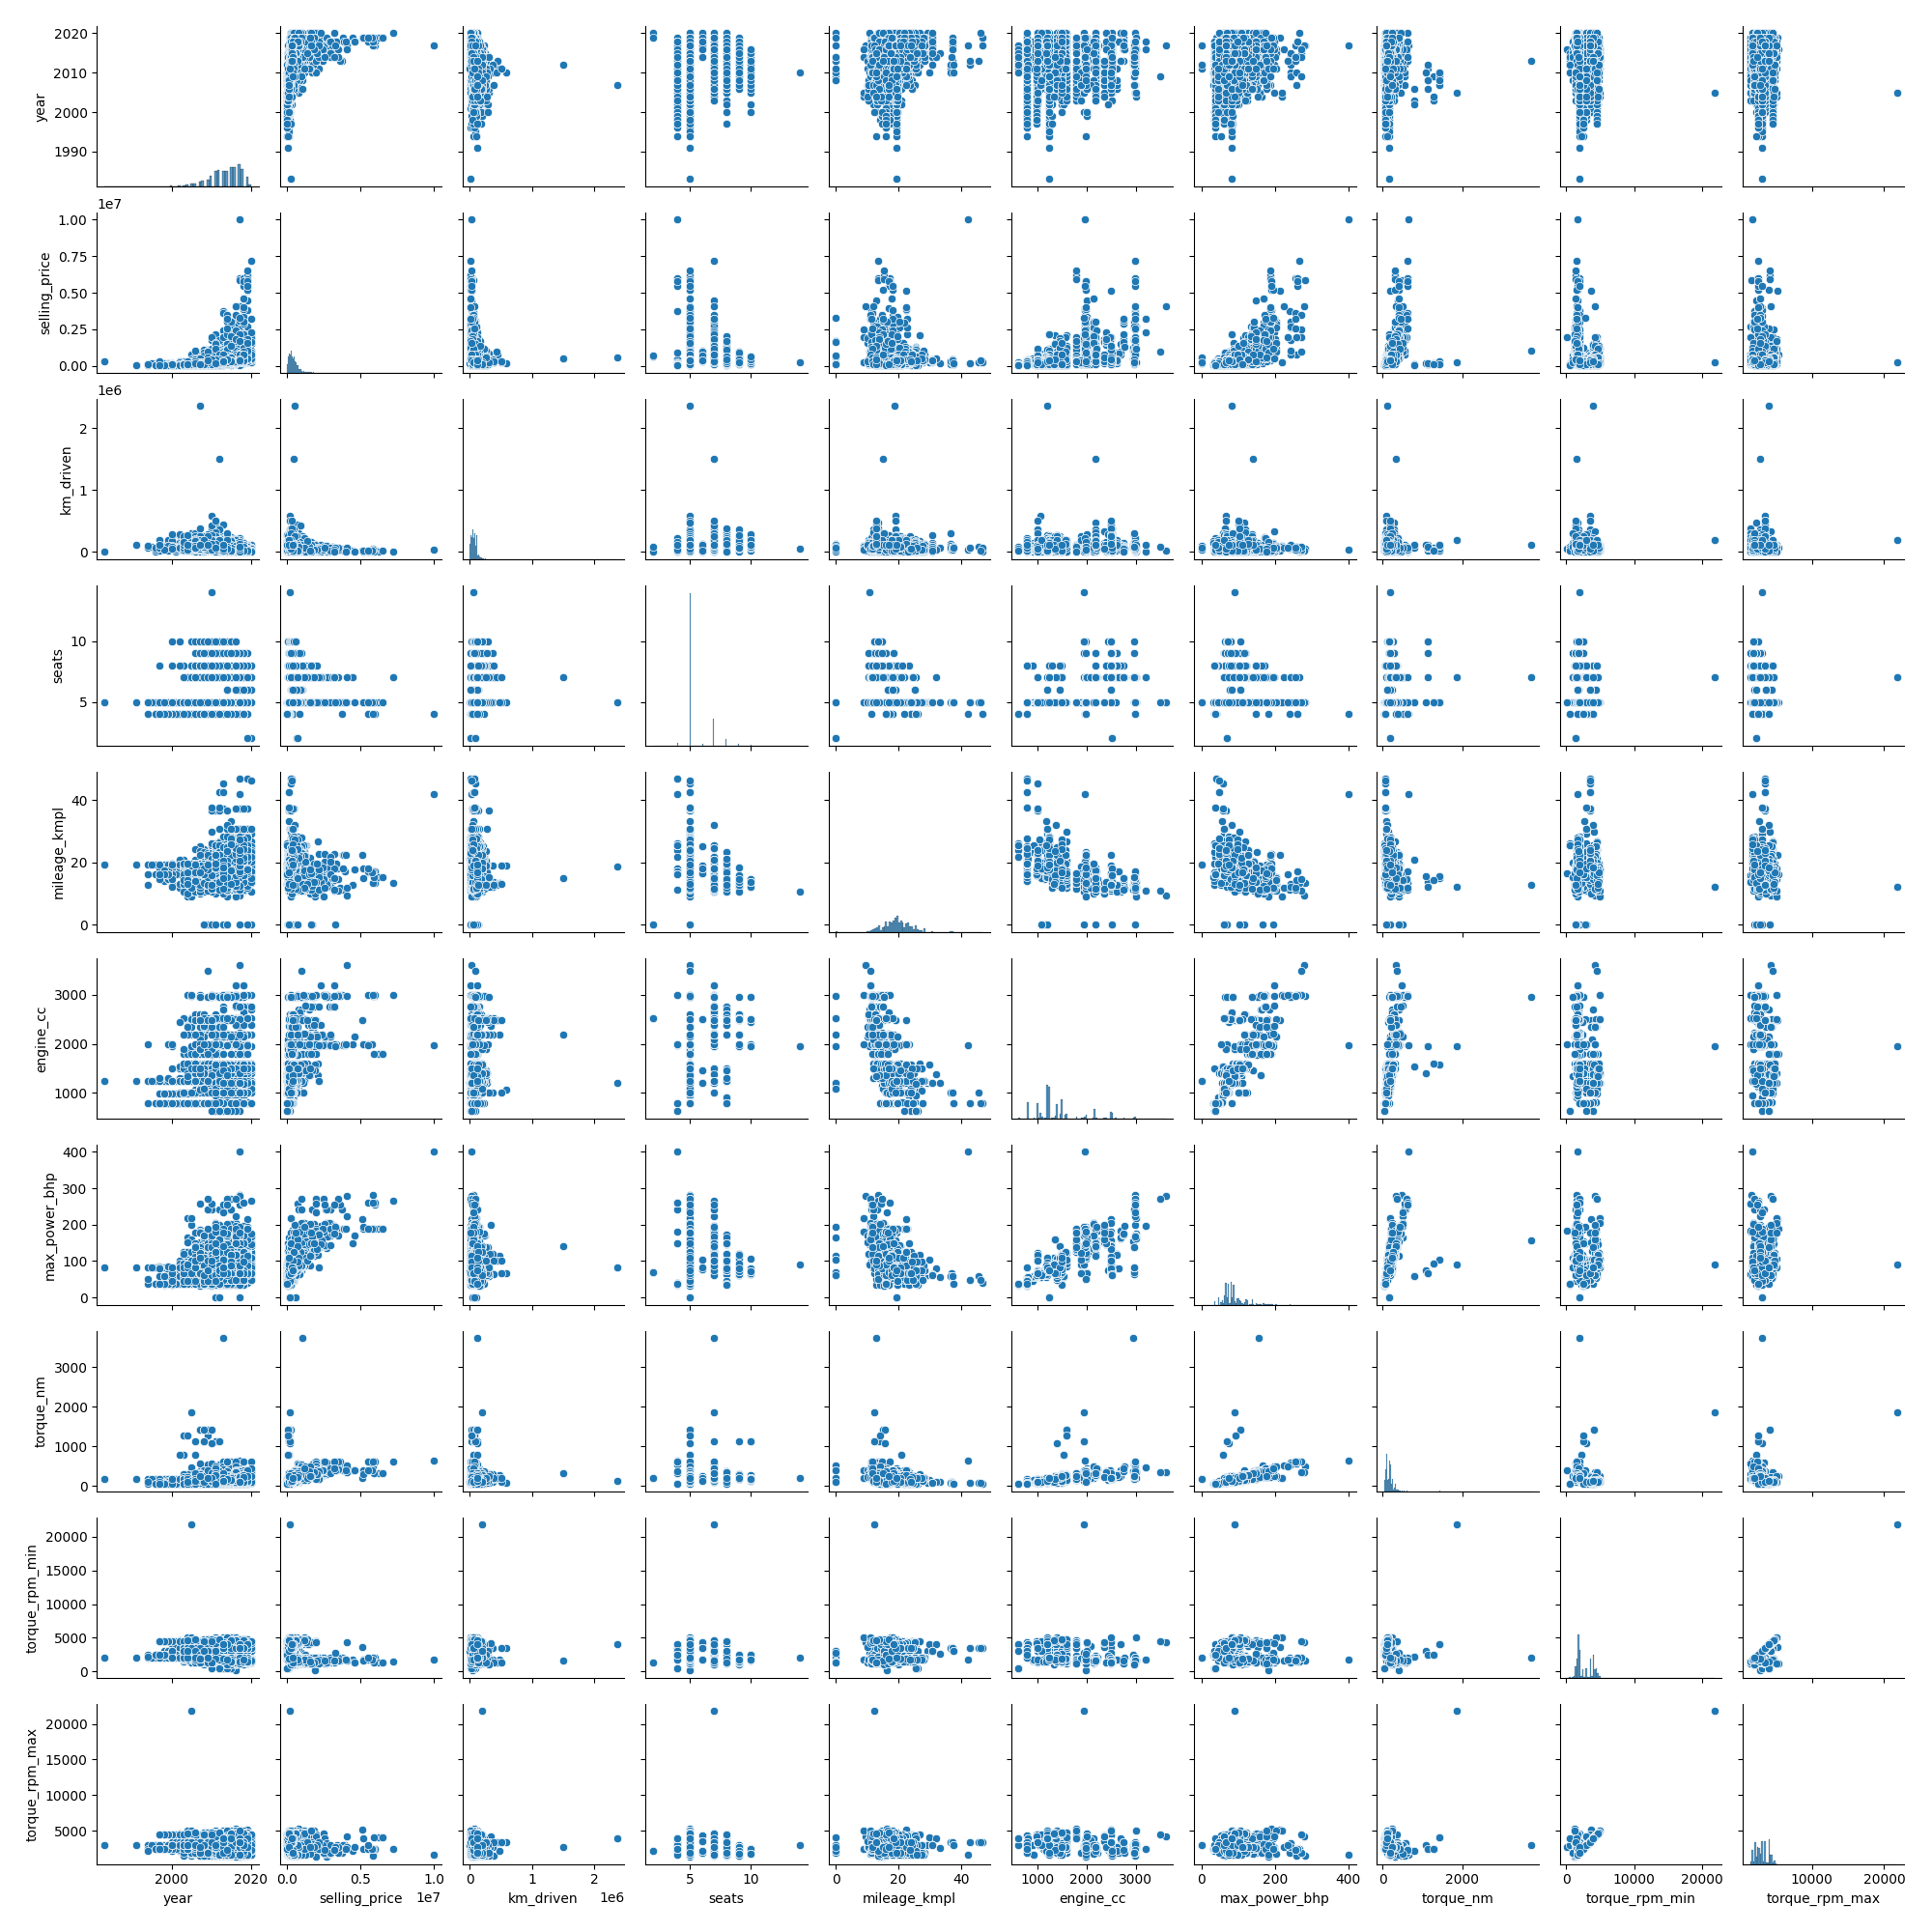

In [12]:
sns.pairplot(df_train_clean, height=2)

### Plot counts of each unique value of a categorial feature

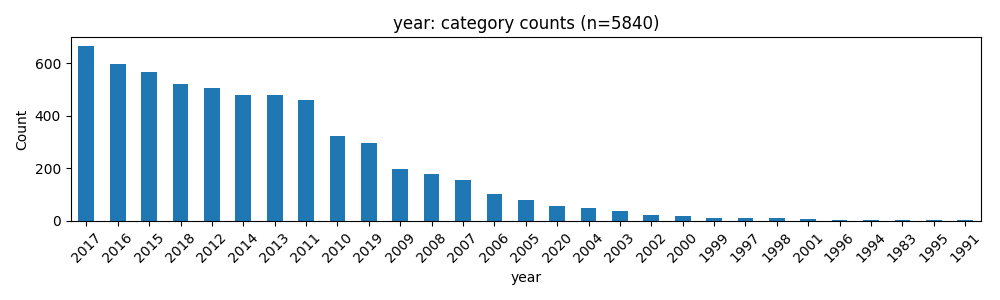

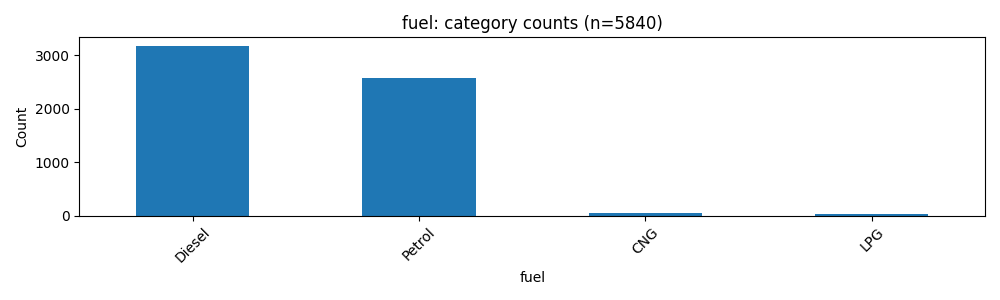

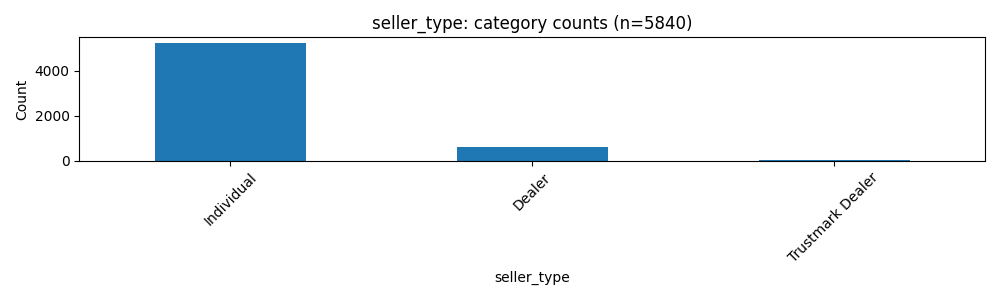

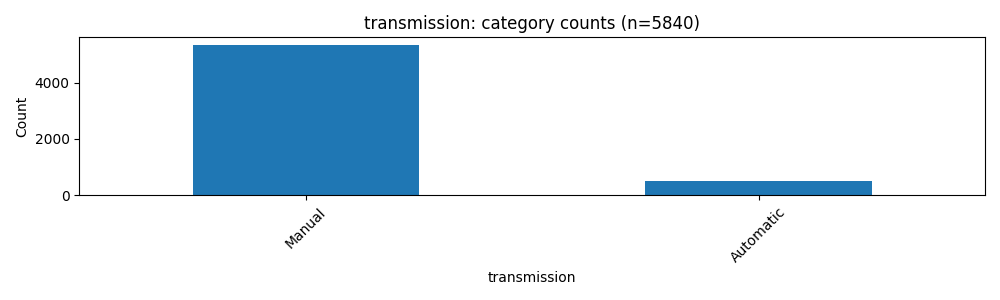

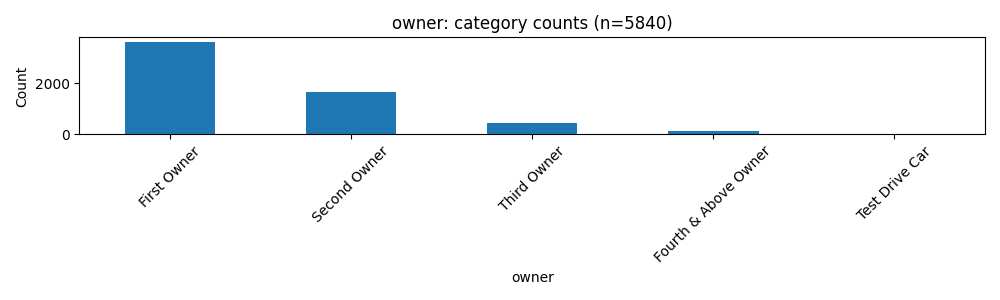

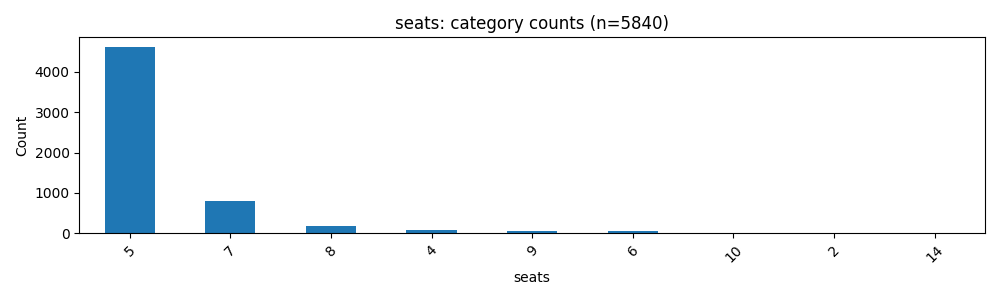

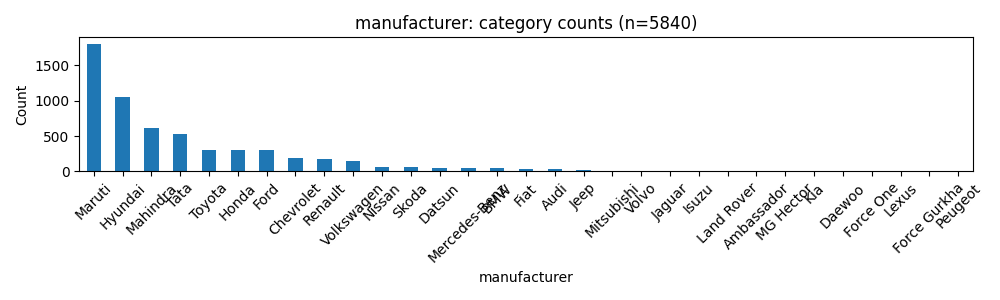

In [13]:
# Unique values of categorial features
for feature in ['year', 'fuel', 'seller_type', 'transmission', 'owner', 'seats', 'manufacturer']:
    val_counts = df_train_clean[feature].value_counts(dropna=True)

    fig, ax = plt.subplots(figsize=(10, 3))
    val_counts.plot(kind="bar", ax=ax)

    ax.set_title(f"{feature}: category counts (n={len(df_train_clean)})")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

### Price distribution

In [14]:
def plot_distribution(values, description, xlabel, ylabel):
    values_median = np.median(values)
    values_mean = np.mean(values)
    _, ax = plt.subplots(figsize=(10, 5))
    ax.hist(values, bins="auto")
    ax.axvline(values_median, linewidth=2, label=f"Median: {values_median:,.3f}", color='green')
    ax.axvline(values_mean, linewidth=2, linestyle="--", label=f"Mean: {values_mean:,.3f}", color='purple')
    ax.set_title(description)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.tight_layout()
    plt.show()

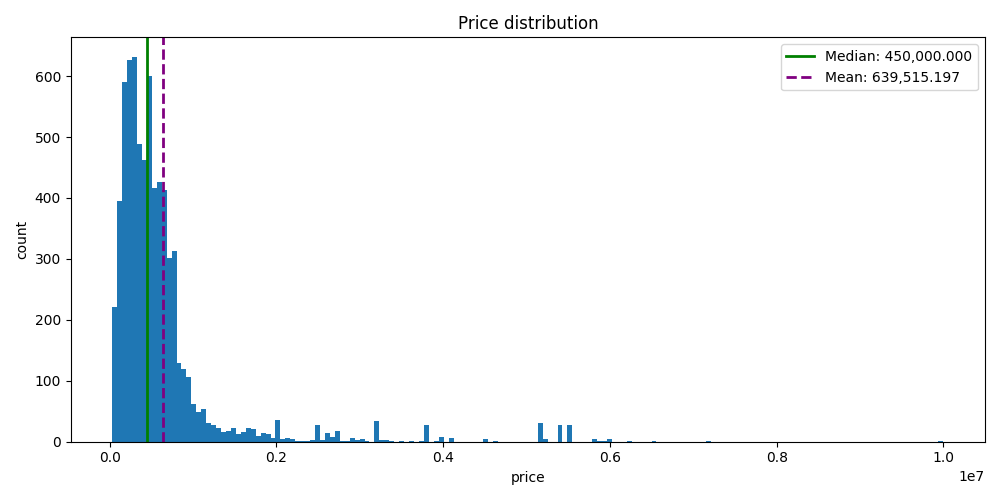

In [15]:
# "Raw" price
price = df_train['selling_price']
plot_distribution(price, "Price distribution", "price", "count")


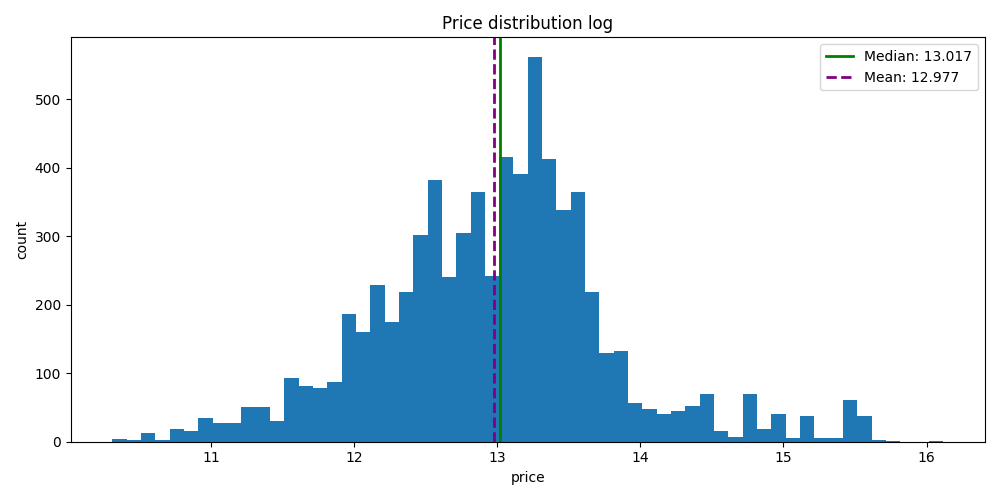

In [16]:
# Logarithmic price
price_log = np.log1p(price)
plot_distribution(price_log, "Price distribution log", "price", "count")

### Numerical features distribution

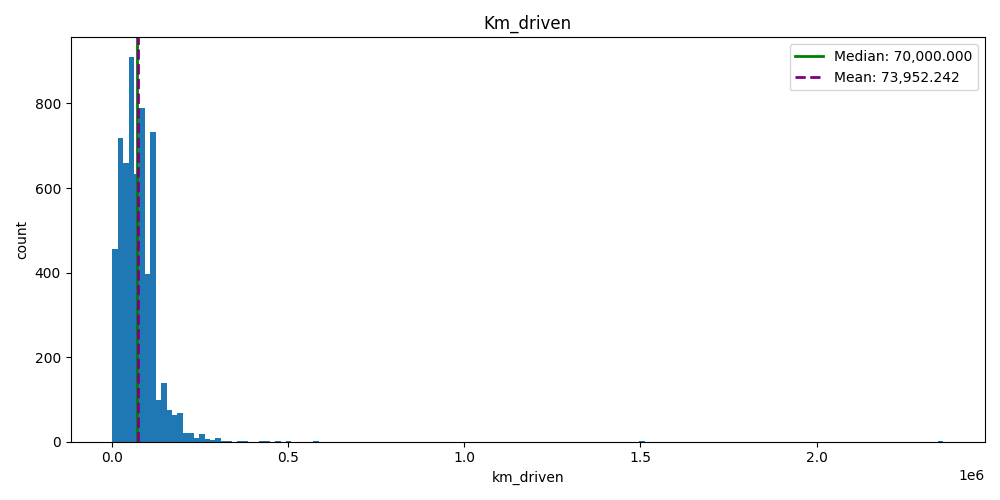

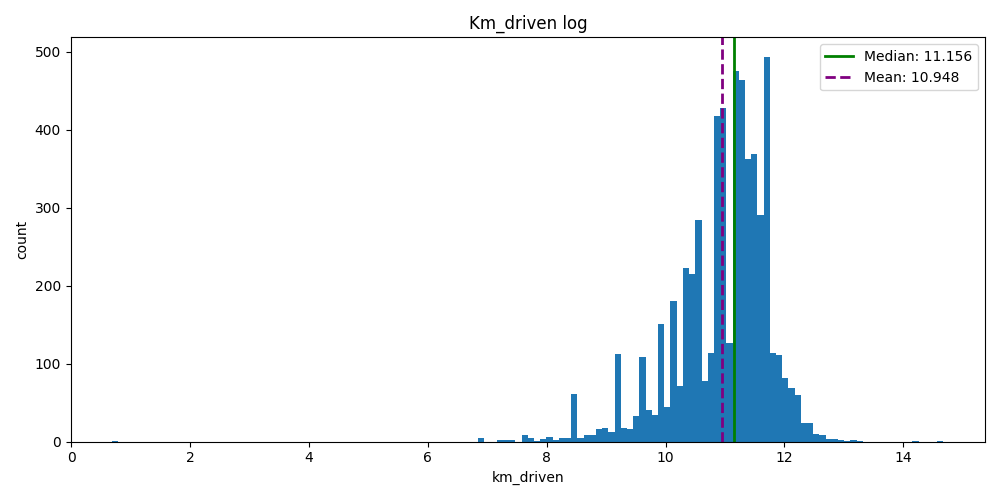

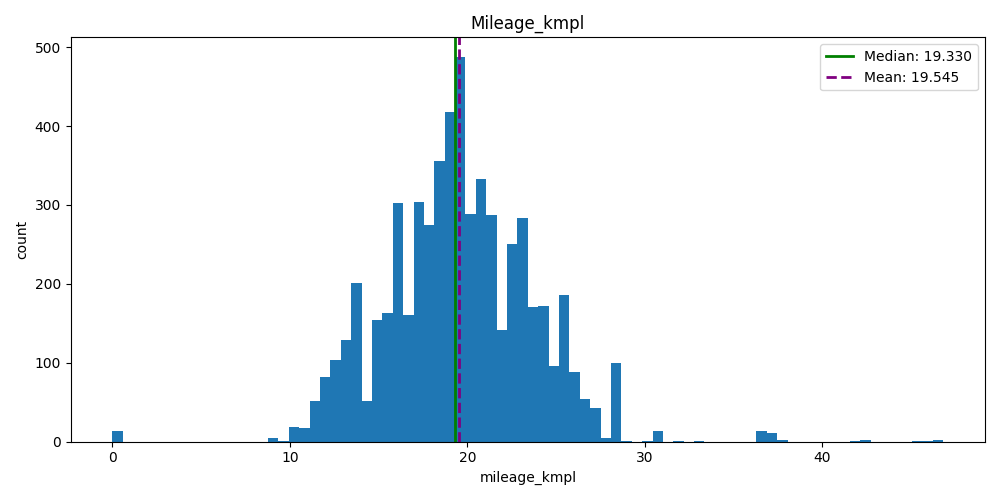

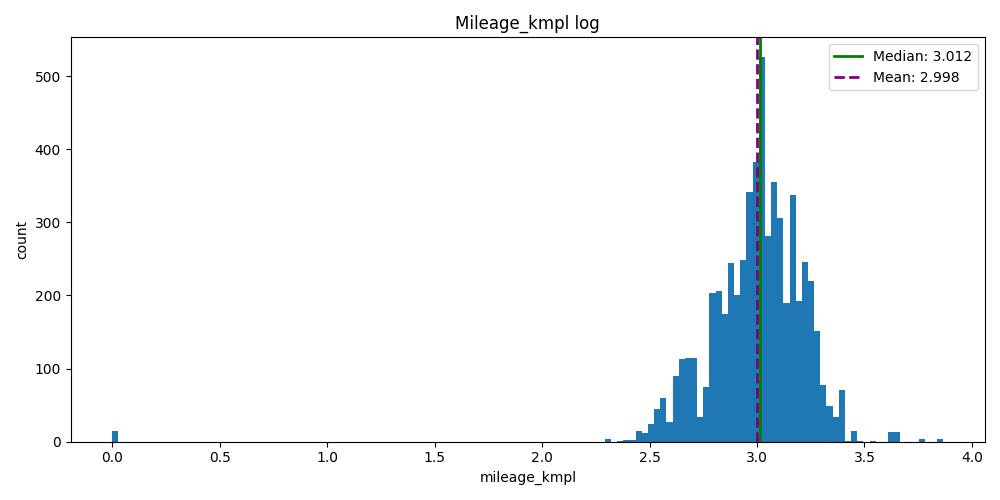

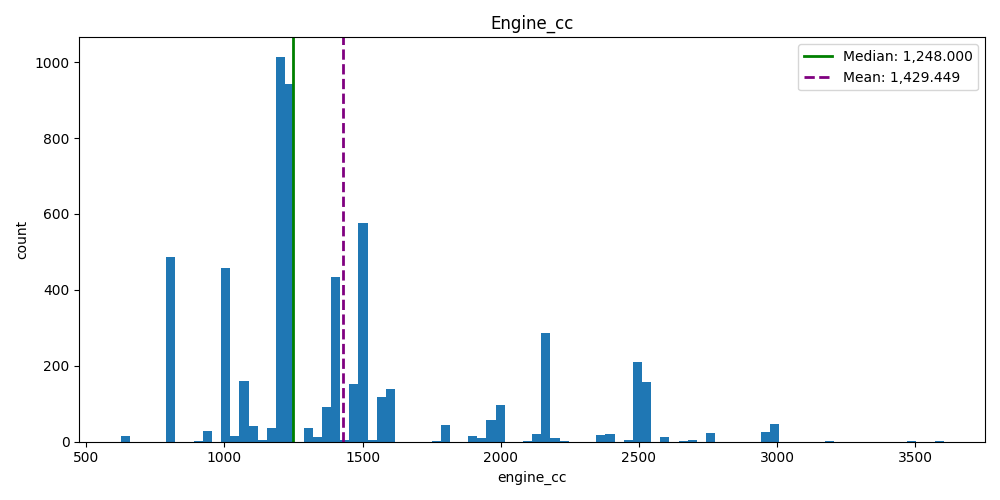

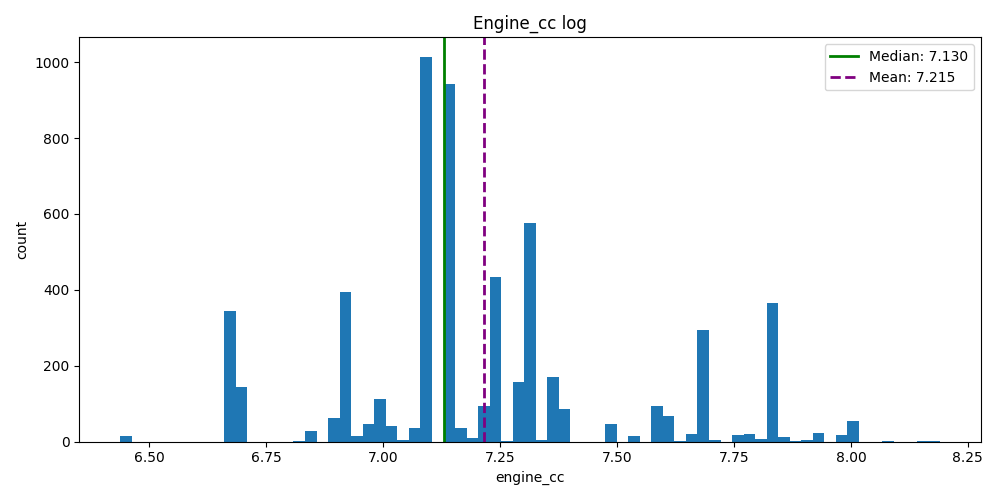

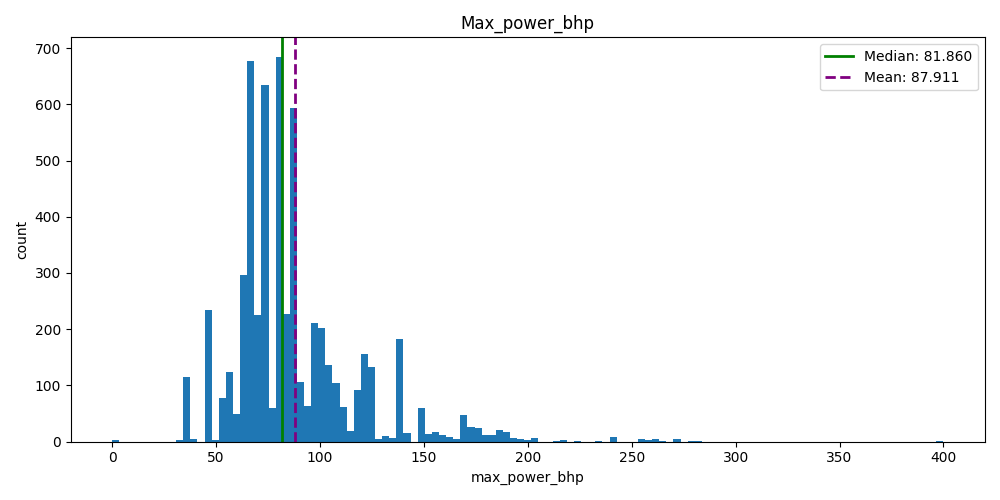

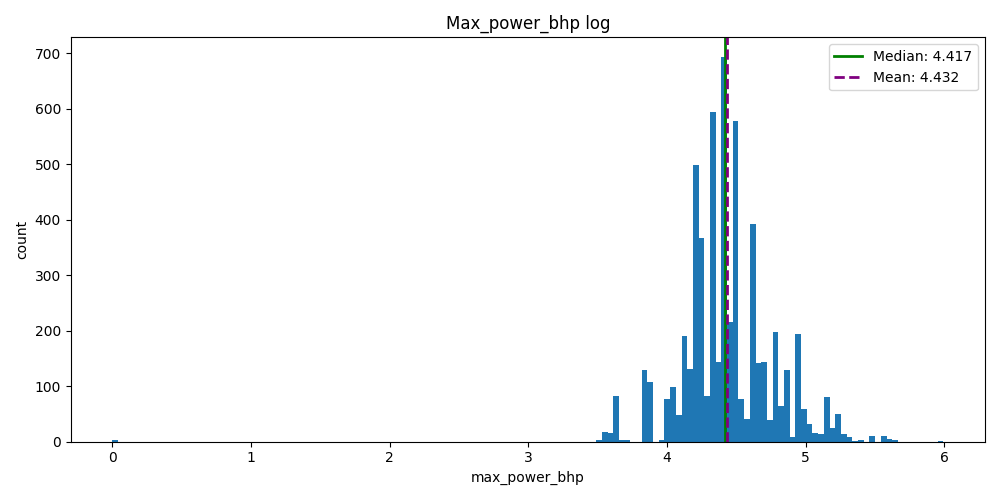

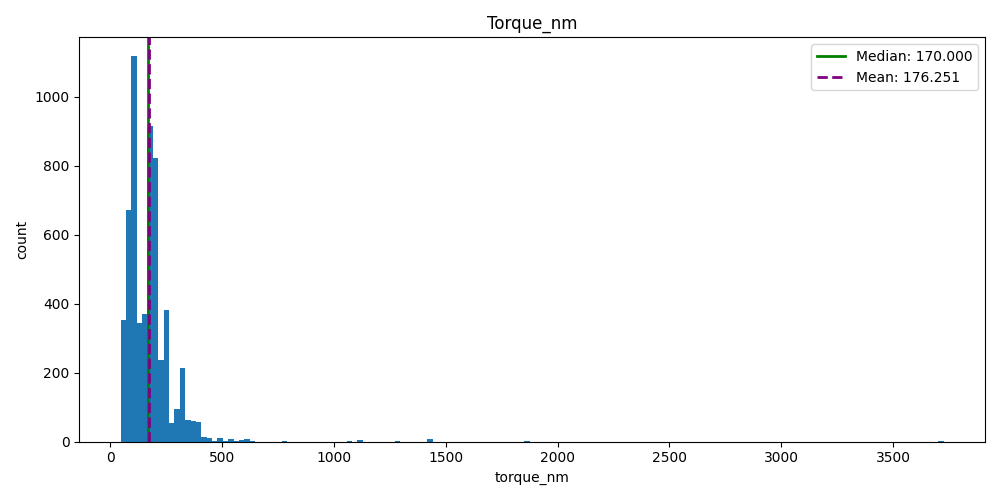

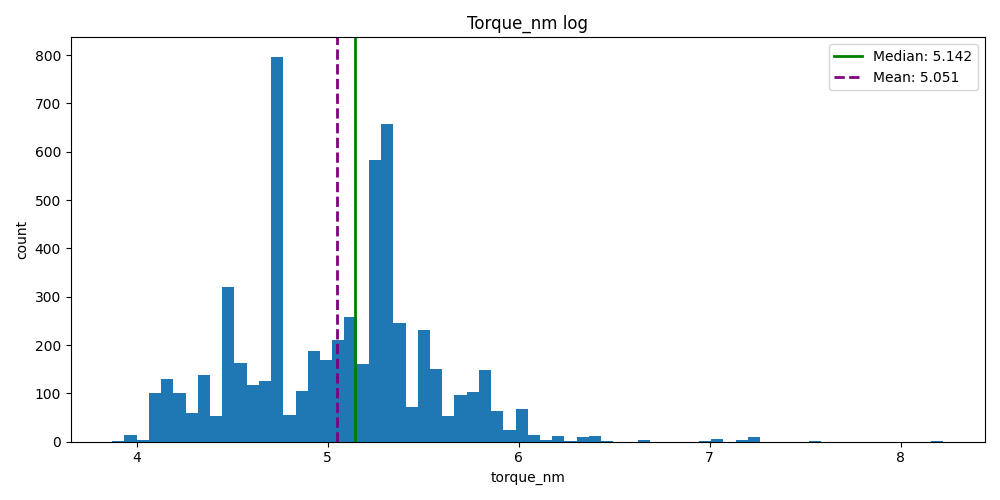

/tmp/ipykernel_246300/2456240906.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=(10, 5))


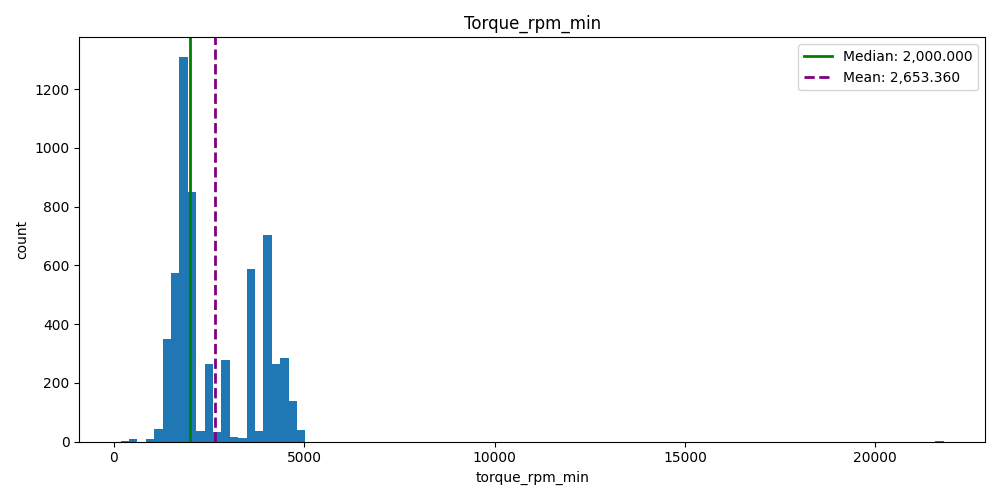

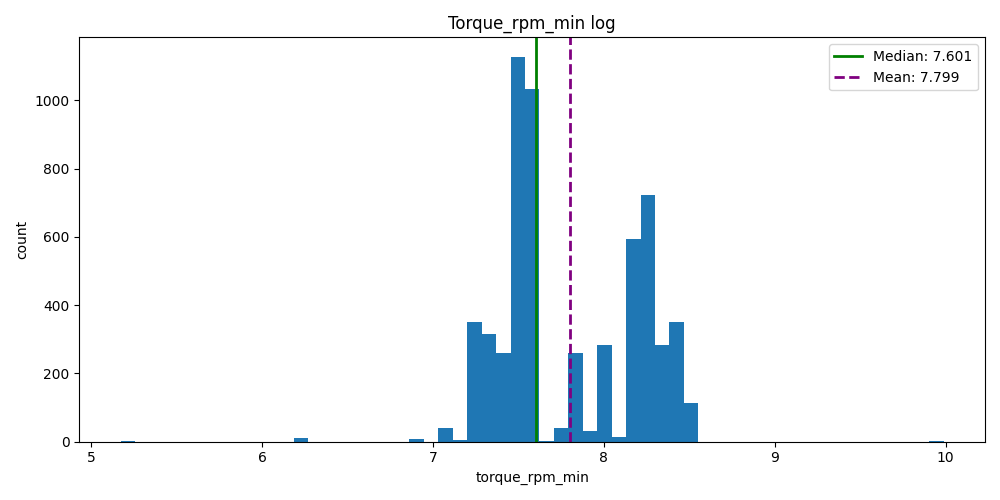

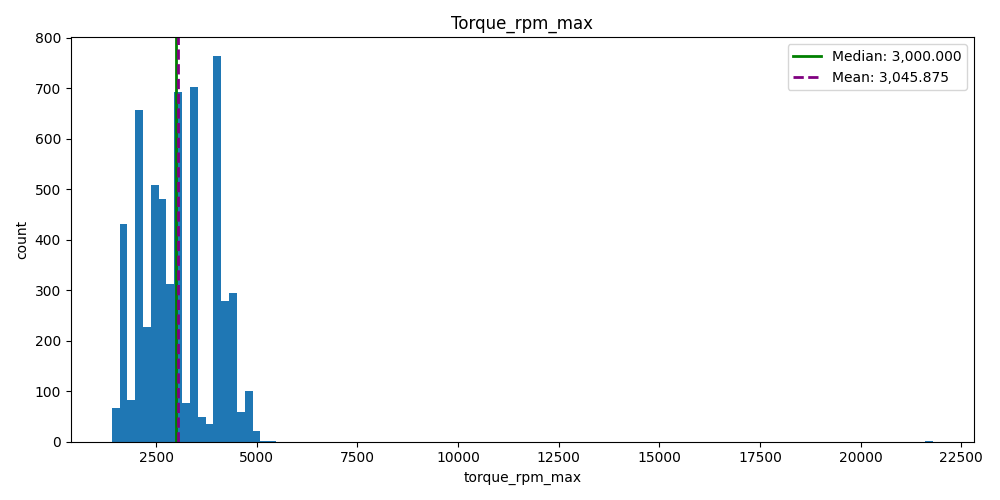

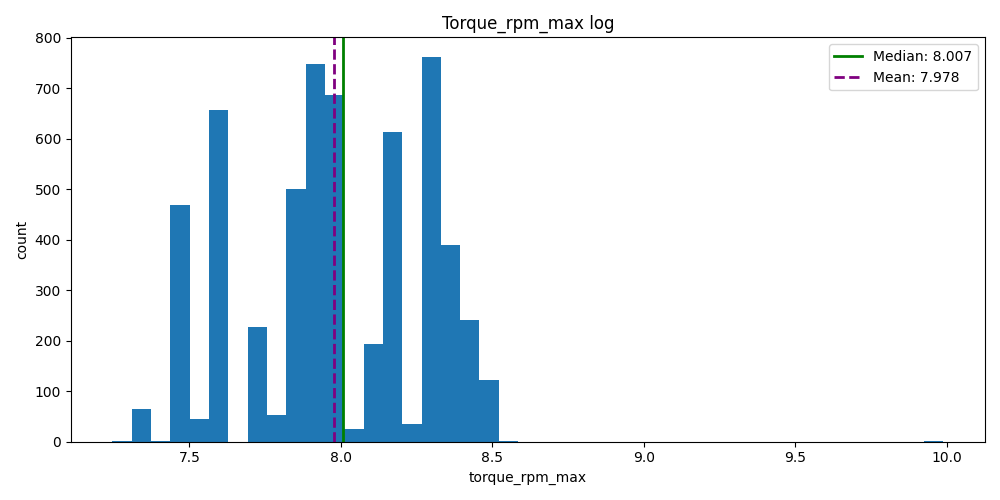

In [17]:
for feature in ['km_driven', 'mileage_kmpl', 'engine_cc', 'max_power_bhp', 'torque_nm', 'torque_rpm_min', 'torque_rpm_max']:
    plot_distribution(df_train_clean[feature], feature.capitalize(), feature, "count")
    plot_distribution(np.log1p(df_train_clean[feature]), f"{feature.capitalize()} log", feature, "count")

### Heatmap

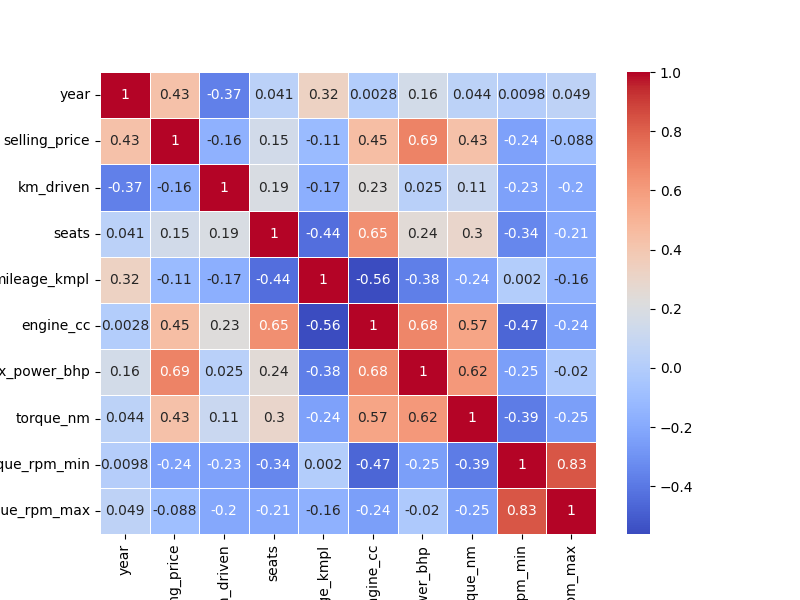

In [18]:
df_train_corr = df_train_clean.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(df_train_corr, annot=True, cmap='coolwarm',linewidth=.5)
plt.show()

Присутствует мультиколлинеарность. Уберем её при помощи регуляризации.

### 3. Models

Построим модели, которые показали себя хорошо в 1 части ДЗ:
- ElasticNet
- Ridge

In [19]:
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE

def print_metrics(y_test: pd.DataFrame, y_pred: pd.DataFrame) -> None:
    r2 = r2_score(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    print(f'R2: {r2}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')

In [20]:
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'seats', 'manufacturer']
num_features = ['year', 'km_driven', 'mileage_kmpl', 'engine_cc', 'max_power_bhp', 'torque_nm', 'torque_rpm_min', 'torque_rpm_max']

In [21]:
y_train = df_train_clean['selling_price']
X_train = df_train_clean[cat_features + num_features]

y_test = df_test_clean['selling_price']
X_test = df_test_clean[cat_features + num_features]

#### ElasticNet

In [22]:
# Let's try ElasticNet as in HW part 1

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), cat_features),
    ]
)

en_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("enet", ElasticNet(max_iter=30000))
])

params = {
    "enet__alpha": np.logspace(-3, -1, 10),
    "enet__l1_ratio": np.arange(0.2, 0.5, 0.02)
}

gs_enet_full = GridSearchCV(
    estimator=en_pipe,
    param_grid=params,
    cv=10,
    scoring="r2",
    verbose=1,
)

gs_enet_full.fit(X_train, y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in column

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...iter=30000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'enet__alpha': array([0.001 ..., 0.1 ]), 'enet__l1_ratio': array([0.2 , ..., 0.46, 0.48])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",10
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 

In [23]:
print(f'Top alpha: {gs_enet_full.best_params_["enet__alpha"]}; Top L1: {gs_enet_full.best_params_["enet__l1_ratio"]}; Top R2: {gs_enet_full.best_score_}')

# Train
y_pred_train_gs_enet_full = gs_enet_full.predict(X_train)
print_metrics(y_train, y_pred_train_gs_enet_full)

# Test
y_pred_gs_enet_full = gs_enet_full.predict(X_test)
print_metrics(y_test, y_pred_gs_enet_full)

Top alpha: 0.001; Top L1: 0.47999999999999987; Top R2: 0.711505604608878
R2: 0.7641328608441943
MSE: 67608564840.84854
MAE: 138400.77221139168
R2: 0.7708480400812936
MSE: 131723090141.78871
MAE: 168413.09164954352


/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### ElasticNet with logarithmic target values

In [24]:
# The prices aren't normally distributed, so let's use log function
# ChatGPT suggested an easy way: use TransformedTargetRegressor.
# It'll pass target through log function, but will output not logarithmic values

from sklearn.compose import TransformedTargetRegressor


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
    ]
)

en_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("enet", ElasticNet(max_iter=30000))
])

en_transformed_model = TransformedTargetRegressor(
    regressor=en_pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

params = {
    "regressor__enet__alpha": np.logspace(-3, -1, 10),
    "regressor__enet__l1_ratio": np.arange(0.02, 0.5, 0.02)
}

gs_enet_transformed = GridSearchCV(
    estimator=en_transformed_model,
    param_grid=params,
    cv=10,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

gs_enet_transformed.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in column

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ter=30000))]))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__enet__alpha': array([0.001 ..., 0.1 ]), 'regressor__enet__l1_ratio': array([0.02, ... 0.46, 0.48])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",10
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold 

In [25]:
print(f'Top alpha: {gs_enet_transformed.best_params_["regressor__enet__alpha"]}; Top L1: {gs_enet_transformed.best_params_["regressor__enet__l1_ratio"]}; Top MAE: {-gs_enet_transformed.best_score_}')

# Train
print('\nTrain:')
y_pred_train_gs_enet_transformed = gs_enet_transformed.predict(X_train)
print_metrics(y_train, y_pred_train_gs_enet_transformed)

# Test
print('\nTest:')
y_pred_gs_enet_transformed = gs_enet_transformed.predict(X_test)
print_metrics(y_test, y_pred_gs_enet_transformed)

Top alpha: 0.001; Top L1: 0.02; Top MAE: 99093.08886611435

Train:
R2: 0.8735037888018655
MSE: 36258663786.40153
MAE: 96865.2101952801

Test:
R2: 0.8802520129480714
MSE: 68834562437.67125
MAE: 118455.35564919356


/home/fiberfox/Projects/HSEAIMag2025/ML_HW1/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### ElasticNet with logarithmic target & feature values

Some features aren't normally distributed. We can apply logarithm to them as well.

In [26]:
from sklearn.pipeline import FunctionTransformer


logarithmic_num_features = ['km_driven', 'torque_nm', 'torque_rpm_min', 'torque_rpm_max']
non_logarithmic_num_features = [f for f in num_features if f not in logarithmic_num_features]

log_transformer = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler()),
])

plain_transformer = Pipeline([
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", log_transformer, logarithmic_num_features),
        ("num_plain", plain_transformer, non_logarithmic_num_features),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

en_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("enet", ElasticNet(max_iter=30000))
])

en_transformed_model = TransformedTargetRegressor(
    regressor=en_pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

params = {
    "regressor__enet__alpha": np.logspace(-3, -1, 10),
    "regressor__enet__l1_ratio": np.arange(0.02, 0.5, 0.02)
}

gs_enet_transformed_log_num_features = GridSearchCV(
    estimator=en_transformed_model,
    param_grid=params,
    cv=10,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

gs_enet_transformed_log_num_features.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ter=30000))]))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__enet__alpha': array([0.001 ..., 0.1 ]), 'regressor__enet__l1_ratio': array([0.02, ... 0.46, 0.48])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",10
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold 

In [27]:
print(f'Top alpha: {gs_enet_transformed_log_num_features.best_params_["regressor__enet__alpha"]}; Top L1: {gs_enet_transformed_log_num_features.best_params_["regressor__enet__l1_ratio"]}; Top MAE: {-gs_enet_transformed_log_num_features.best_score_}')

# Train
print('\nTrain:')
y_pred_train_gs_enet_transformed_log_num_features = gs_enet_transformed_log_num_features.predict(X_train)
print_metrics(y_train, y_pred_train_gs_enet_transformed_log_num_features)

# Test
print('\nTest:')
y_pred_gs_enet_transformed_log_num_features = gs_enet_transformed_log_num_features.predict(X_test)
print_metrics(y_test, y_pred_gs_enet_transformed_log_num_features)

Top alpha: 0.001; Top L1: 0.02; Top MAE: 98311.5023356839

Train:
R2: 0.8755637365073782
MSE: 35668203798.98926
MAE: 96082.30815336807

Test:
R2: 0.8829623724999089
MSE: 67276570371.22764
MAE: 116429.26559061575


## Results

| Model  |R^2|MSE|MAE|
|---|---|---|---|
| ElasticNet (all features, without logarithm) |0.770|131723090141|168413|
| ElasticNet (all features, with logarithmic target) | 0.880 | 68834562437 | 118455|
| ElasticNet (all features, with logarithmic target and numerical features) |0.882 |67276570371 |116429 |

The best model is ElasticNet with logarithmic target and numerical features.

## Save model

In [28]:
import joblib


joblib.dump(gs_enet_transformed_log_num_features, '../models/model.pickle')

['../models/model.pickle']